In [9]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

from imutils import rotate_bound
from math import ceil
from random import randint, shuffle


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


Input image:


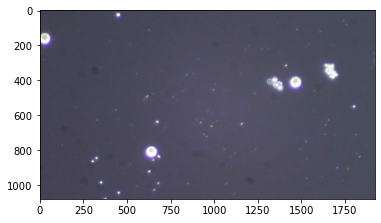

In [10]:
# Load the dataset
train_data_path= os.path.join("..", "data", "wafer", "1.jpg")

print("Input image:")
image = cv2.imread(train_data_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()


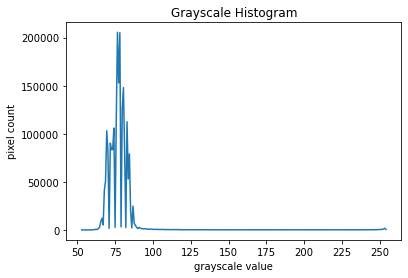

In [11]:
def get_gray(image):
    r, g, b = image[:,:,0], image[:,:,1], image[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

def plot_intensity_histogram(image):
    # <input> image: a color (3 channels) image
    # <output>: plot with the grayscale intensity histogram
    gray=get_gray(image)
    
    histogram, bin_edges = np.histogram(gray, bins=256)
    
    plt.title("Grayscale Histogram")
    plt.xlabel("grayscale value")
    plt.ylabel("pixel count")
    plt.plot(bin_edges[0:-1], histogram)  #

plot_intensity_histogram(image) 

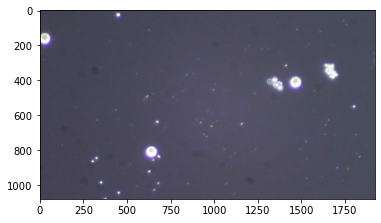

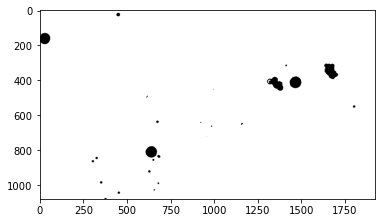

In [20]:
def segment_image(image, fuse_th, metal_th):
    image=get_gray(image)
    
    metal_bw = np.invert(image > metal_th) 
    fuse_bw = np.invert(image >= fuse_th) 
    

#     fig = plt.figure(figsize=(27,9))
    plt.imshow(fuse_bw, cmap="gray")
    plt.show()
    
#     fig = plt.figure(figsize=(27,9))
#     plt.imshow(metal_bw, cmap="gray")
#     plt.show()

    return [fuse_bw, metal_bw]

plt.imshow(image)
plt.show()
fuse_bw, metal_bw = segment_image(image,150,100) # You can use this line of code to test your thresholds


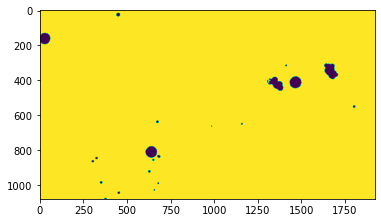

In [25]:
def label_regions(binary_image):
    # <input> binary_image: an image containing foreground in white and background in black
    # <return>: labeled_image: a single-channel image, where each connected set in the clean version of "binary_image" is assigned to a numeric label (with background = 0)
    
    image = np.array(binary_image, dtype=np.uint8)
    
    kernel = np.ones((5,5),np.uint8)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
                   
    number_of_components, labeled_image = cv2.connectedComponents(image)
                                   
    return labeled_image

labeled_image=label_regions(fuse_bw)
labeled_image=np.array(labeled_image, dtype=np.uint8)
plt.imshow(labeled_image)
plt.show()

In [26]:
def print_regions(labeled_image):
    counter=1
    img=labeled_image.copy
    while True:
        mask = np.array(img, dtype=np.uint8)
        if mask[img == counter].any():
            mask[img == counter]= 255
        else:
            break
#         fig = plt.figure(figsize=(27,9))
#         plt.imshow(mask, cmap="gray")
#         plt.show()
        counter+=1
    return counter

count=print_regions(labeled_image)
print(count)


TypeError: int() argument must be a string, a bytes-like object or a number, not 'builtin_function_or_method'

In [ ]:
#@title Time to detect damaged fuses

# The function written in the previous block will come in handy
# Using the labeling function, you will analyze the properties of the metal parts to determine the pieces that are damaged
# You will write a function that takes as input metal_bw; it returns an image containing only damaged fuses

from skimage.measure import regionprops


def segment_damaged_fuses(image):
    # <input> image: a binary image containing the metal pieces of the fuses
    # <return> damaged_metal_bw: a binary image containing the metal parts of the damaged fuses only (in white)
    img=image.copy()
    regions = label_regions(image)
    region_idxs = np.unique(regions)
    
    props = regionprops(regions)  # https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops
    area_sum=0
    for region_prop in props:
        area_sum += region_prop.area
    treshold=area_sum/(len(region_idxs)-1) # automatic treshold between 2 groups
    
    for region_prop in props:
        if region_prop.area > treshold: # if region area is greater than treshold
            idx=region_prop.label            
            img[regions == idx]= 0  # turn region area black

    return img

damaged_fuses = segment_damaged_fuses(metal_bw)



In [ ]:
def sort_fuses(fuses,defective_metal_pieces):
    num_fuses=len(np.unique(fuses))

    damaged_fuses = np.zeros(fuses.shape, dtype=np.uint8) 
    nondamaged_fuses = np.zeros(fuses.shape, dtype=np.uint8)    
    fuses = np.array(fuses, dtype=np.uint8)
    defective_metal_pieces = np.array(defective_metal_pieces, dtype=np.uint8)
    
    for region_idx in range(1,num_fuses):
        mask = np.array(fuses, dtype=np.uint8)
        if mask[fuses == region_idx].any():
            mask[fuses == region_idx]= 255
            mask[fuses != region_idx]= 0
        intersection = cv2.bitwise_and(defective_metal_pieces,mask)
        if intersection.any():
            damaged_fuses=cv2.bitwise_or(damaged_fuses,mask)
        else:
            nondamaged_fuses=cv2.bitwise_or(nondamaged_fuses,mask)  

    return damaged_fuses, nondamaged_fuses


def color_img(orig_img,regions,color_idx):
    region_num = len(np.unique(regions))
    img = orig_img.copy()
    
    mask= cv2.cvtColor(regions, cv2.COLOR_GRAY2BGR )
    colors = [[1,0,0],[0,1,0],[0,0,1]]
    colored_mask = np.multiply(mask, colors[color_idx])
    img = img+colored_mask

    return img

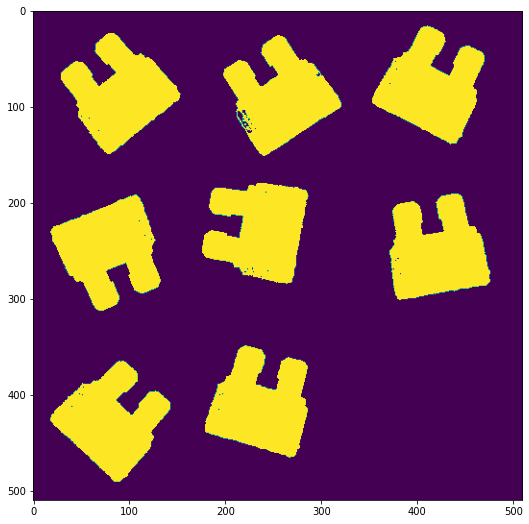

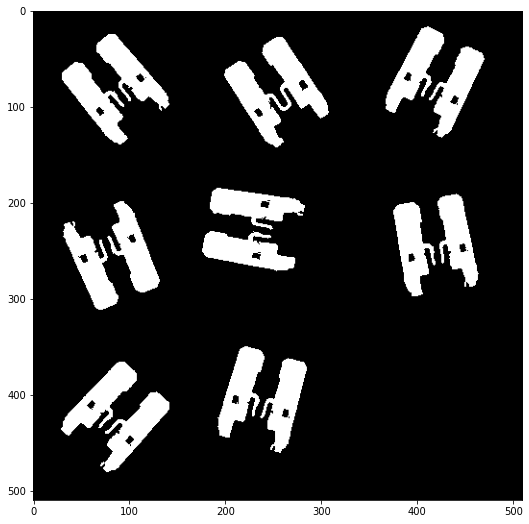

Number of fuses: 8
Number of damaged fuses: 7


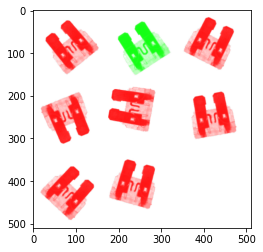

In [ ]:
#@title Time to make conclusions

# Using the functions written so far, lets get the expected outputs
# Remember, you are asked to:
#
# 1.   Count the number of fuses in an image
# 2.   Indentify if there are damaged fuses in an image
# 3.   If there are damaged fuses, return the number of damaged ones
# 4.   Return an image where the damaged fuses (if any) have an intensity of 255 in the red channel, and the good ones an intensity of 255 in the green channel
#
# You will write a final function that does all of this

def analyze_image(generated_image, fuse_th, metal_th):

    fuse_bw, metal_bw = segment_image(generated_image, fuse_th, metal_th)

    labeled_fuses = label_regions(fuse_bw)
    num_fuses = len(np.unique(label_regions(fuse_bw)))-1 # To complete. This variable corresponds to the number of fuses in the image

    defective_metal_pieces = segment_damaged_fuses(metal_bw)
    num_damaged_fuses =int((len(np.unique(label_regions(defective_metal_pieces)))-1) /2) # To complete. This variable corresponds to the number of damaged fuses in the image
    
    damaged_fuses, nondamaged_fuses=sort_fuses(labeled_fuses,defective_metal_pieces)

    c_img=color_img(generated_image,damaged_fuses,0)
    c_img=color_img(c_img,nondamaged_fuses,1)
    labeled_image = np.copy(c_img)  # This is the image that will be displayed to show the damaged fuses in red and the good ones in green
    
    print("Number of fuses: %s" % num_fuses)
    print("Number of damaged fuses: %s" % num_damaged_fuses)
    plt.imshow(labeled_image)
    plt.show()

analyze_image(generated_image, 225,100)


# Homework (or to be done during the practical session if you have enought time)

In this activity, you worked with a nice image. However, this is not always the case. In this section, the analyzed image will be altered so that choosing hard thresholds is not enough to provide a good segmentation.

You will discover how to use filters to compensate for variable lightning along the image. Remember that linear filtering is the key concept behind convolutional neural networks, which will be the core of our next practical session.

The next block of code contains the function that will randomly modify the lightning of the image to analyze.

In [ ]:
#@title change_lightning() code

def get_oriented_gradient(image_size, slope, center, low, high):

    canvas = np.zeros(image_size, np.float)
    slope *= -1  # Since the vertical axis increases downwards in images
    y_cen = int(center * image_size[0])
    x_cen = int(center * image_size[1])
    alpha_step_size = 0.5*(high+low) / x_cen
    # Given a known point of the center line, and it's slope, calculate the x-coordinates of the extreme points
    x_2_0 = int(-(y_cen + x_cen) / slope)
    x_1_0 = int(((image_size[1] - 1) - (y_cen + x_cen)) / slope)

    # Calculate alphas for dark area
    alpha = 0.5*(high+low)
    for x in range(max(x_1_0, x_2_0)):
        # The alphas are assigned line-wise with lines parallel to the input slope
        canvas = cv2.line(canvas, (x_1_0 - x, image_size[0] - 1), (x_2_0 - x, 0), color=max(low, alpha), thickness=1)
        alpha -= alpha_step_size  # As move along the image, alpha changes
    # Calculate alphas for bright area
    alpha = 0.5*(high+low)
    for x in range(image_size[1] - min(x_1_0, x_2_0)):
        canvas = cv2.line(canvas, (x_1_0 + x, image_size[0] - 1), (x_2_0 + x, 0), color=min(high, alpha), thickness=1)
        alpha += alpha_step_size

    return cv2.medianBlur(canvas.astype(np.float32), 5)

def change_lightning(image):

    slope = np.random.normal(2.0, 0.2)
    center = np.random.normal(0.5, 0.05)
    low = randint(5,7)/10
    high = randint(8,10)/10

    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    gradient = get_oriented_gradient(image.shape, slope, center, low, high)
    modified_image = gradient * image

    return modified_image

Below you will see a comparison between the original image and the altered one. Notice that there is a shadow progressively getting darker. Of course, the histograms of both images are different.

In [ ]:
#@title Good vs bad light

plt.imshow(cv2.cvtColor(generated_image, cv2.COLOR_BGR2GRAY), cmap="gray")
plt.clim(0,255)
plt.show()
plt.imshow(change_lightning(generated_image), cmap="gray")
plt.clim(0,255)
plt.show()

To deal with this problem, we will try to supress the shadows using a Gaussian filter to substract (locally) the mean intensity from the image. This means that, region-wise, we will make the mean pixel intensity approximetely equal to 0.

In [ ]:
#@title Mean substraction

# Here, you will write a function that calculates the local mean intensity of an image using a Gaussial filter
# Afterwards, you will substract this mean to get an image that contains, region-wise, a mean intensity approximetely equal to 0
# Finally, you will shift and equalize the histogram of this image to be contained between 0 and 255 (unisgned 8-bits integer)

def mean_substraction(image, kernel_size, sigma):
    img=image.copy()
    local_mean_intensity = cv2.GaussianBlur(image.copy(), kernel_size, 0) # https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#gaabe8c836e97159a9193fb0b11ac52cf1

    zero_intensity_image = np.array(local_mean_intensity, dtype=np.uint8) # Remember that the grayscale image uses unsigned 8-bits integers
    standard_deviation = np.std(image) # We will map the image from [-3*std, 3*std] to [0, 255]
    
    output = ((img - local_mean_intensity)*85) / (standard_deviation) 
    output = output * 255
    
    img = np.array(img <= output) 
    img = np.array(img, dtype=np.uint8)

    kernel = np.ones((7,7),np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
                   
    regions=label_regions(img) # segment

    _,mask = cv2.threshold(img,0,254,cv2.THRESH_BINARY) # create mask
    img = np.array(image, dtype=np.uint8)

    clean_image = cv2.bitwise_or( img, img, mask= mask ) # apply mask

    mask = cv2.bitwise_not(mask)  # create background
    mask = mask.astype(np.uint8)
    
    # print(np.max(mask))
    # print(clean_image.shape,clean_image.dtype)
    # print(mask.shape,mask.dtype)

    new_image = np.maximum( clean_image, mask )

    return new_image

image=change_lightning(generated_image.copy())
p=mean_substraction(image, (3,3), 0)


Lets try your code and its results on different images. Modify the kernel size and sigma until you are satisfied with the results

In [ ]:
kernel_size = (5, 5)
sigma = 1

for i in range(3):

    print("Raw image/Clean image")
    raw_image = change_lightning(generated_image)
    clean_image = mean_substraction(raw_image, kernel_size, sigma)

    plt.imshow(np.concatenate((raw_image, clean_image), axis=1), cmap="gray")
    plt.clim(0,255)
    plt.show()

In [ ]:
# bitwise_and( src, src, res, dst );
# clean_image = cv2.bitwise_and(img,mask) # Remember to return an unsigned 8-bits array

In [ ]:
#@title generate_image() code
!pip install imutils
import numpy as np

from imutils import rotate_bound
from math import ceil
from random import randint, shuffle

def generate_image(number_of_fuses):

    img_fuse = cv2.imread("fuse.png")
    img_fuse = cv2.cvtColor(img_fuse, cv2.COLOR_BGR2RGB)
    img_damaged_fuse = cv2.imread("damaged_fuse.png")
    img_damaged_fuse = cv2.cvtColor(img_damaged_fuse, cv2.COLOR_BGR2RGB)

    shape = img_fuse.shape
    radius = ceil((shape[0]**2 + shape[1]**2)**0.5)

    num_cols = ceil(number_of_fuses**0.5)

    generated_image = 255*np.ones((num_cols*radius, num_cols*radius, 3), dtype=np.uint8)
    number_of_damaged_fuses = randint(0, number_of_fuses)

    class_labels = [i < number_of_damaged_fuses for i in range(number_of_fuses)]
    shuffle(class_labels)

    for i in range(number_of_fuses):
        row = i // num_cols
        col = i % num_cols

        angle = randint(0, 359)

        original_image = np.copy(img_damaged_fuse) if class_labels[i] else np.copy(img_fuse)
        rotated_image = rotate_bound(255 - original_image, angle)
        final_image = 255*np.ones((radius, radius, 3), dtype=np.uint8)
        ri_rows, ri_cols, _ = rotated_image.shape
        final_image[:ri_rows, :ri_cols, :] = 255 -rotated_image

        generated_image[row*radius:(row+1)*radius, col*radius:(col+1)*radius, :] = final_image



    return [generated_image, number_of_fuses, number_of_damaged_fuses]